<a href="https://colab.research.google.com/github/BHUVANA535/image_steganography/blob/main/image_Steganography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.misc
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from keras.models import Model
from keras.preprocessing import image

In [3]:
import zipfile

# Specify the file path
zip_path = '/content/dip_dataset.zip'
extract_path = '/content/dataset_dip/'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the contents
import os
print(os.listdir(extract_path))

['dip_dataset']


In [11]:
IMG_SHAPE = (64, 64)

import os
import random
import numpy as np
from keras.preprocessing import image

def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets from Tiny ImageNet Visual Recognition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into test dataset.

    Returns:
        X_train, X_test: Training and testing data as numpy arrays.
    """
    X_train = []
    X_test = []

    # Create training set.
    for class_name in os.listdir(TRAIN_DIR):
        class_dir = os.path.join(TRAIN_DIR, class_name, 'images')
        class_imgs = os.listdir(class_dir)
        random.shuffle(class_imgs)

        for img_name in class_imgs[:num_images_per_class_train]:
            img_path = os.path.join(class_dir, img_name)
            img = image.load_img(img_path, target_size=IMG_SHAPE)
            img_array = image.img_to_array(img)
            X_train.append(img_array)

    # Shuffle the training data
    X_train = np.array(X_train)
    random.shuffle(X_train)

    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)

    for img_name in test_imgs[:num_images_test]:
        img_path = os.path.join(test_dir, img_name)
        img = image.load_img(img_path, target_size=IMG_SHAPE)
        img_array = image.img_to_array(img)
        X_test.append(img_array)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig / 255.0
X_test = X_test_orig / 255.0

# Print statistics.
print(f"Number of training examples = {X_train.shape[0]}")
print(f"Number of test examples = {X_test.shape[0]}")
print(f"X_train shape: {X_train.shape}")  # Should be (train_size, 64, 64, 3

Number of training examples = 60
Number of test examples = 500
X_train shape: (60, 64, 64, 3)


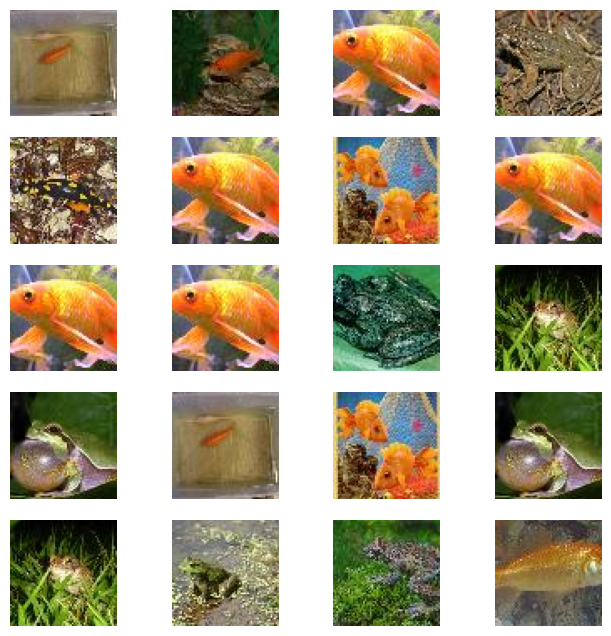

In [12]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(X_train[img_idx])
plt.show()

In [13]:
# S: secret image (first half of training set)
input_S = X_train[:X_train.shape[0] // 2]

# C: cover image (second half of training set)
input_C = X_train[X_train.shape[0] // 2:]

import keras.backend as K

# Beta for scaling secret image loss
beta = 1.0
import tensorflow as tf

# Loss for reveal network: beta * |S - S'|
def rev_loss(s_true, s_pred):
    return beta * tf.reduce_sum(tf.square(s_true - s_pred))


# Loss for the full model (used for preparation and hiding networks):
# |C - C'| + beta * |S - S'|
def full_loss(y_true, y_pred):
    # Split the true and predicted values into secret (S) and cover (C)
    s_true, c_true = y_true[..., 0:3], y_true[..., 3:6]
    s_pred, c_pred = y_pred[..., 0:3], y_pred[..., 3:6]

    # Calculate the loss for the secret image (reveal network)
    s_loss = rev_loss(s_true, s_pred)

    # Calculate the loss for the cover image (hiding network)
    c_loss = K.sum(K.square(c_true - c_pred))

    # Return the total loss
    return s_loss + c_loss

In [14]:
from keras.layers import Input, Conv2D, concatenate

def make_encoder(input_size):
    # Input layers for secret and cover images
    input_S = Input(shape=(input_size))
    input_C = Input(shape=(input_size))

    # Preparation Network: Process secret image
    x = concatenate([
        Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S),
        Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S),
        Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    ])

    x = concatenate([
        Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x),
        Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x),
        Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    ])

    # Concatenate cover image (C) with the output of the preparation network
    x = concatenate([input_C, x])

    # Hiding Network: Process the concatenated input
    for i in range(4):
        x = concatenate([
            Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name=f'conv_hid{i}_3x3')(x),
            Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name=f'conv_hid{i}_4x4')(x),
            Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name=f'conv_hid{i}_5x5')(x)
        ])

    # Output layer for the cover image (C')
    output_Cprime = Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='relu', name='output_C')(x)

    # Return the encoder model
    return Model(inputs=[input_S, input_C], outputs=output_Cprime, name='Encoder')


In [15]:
from keras.models import Model
from keras.layers import Input, Conv2D, GaussianNoise, concatenate

def make_decoder(input_size, fixed=False):
    # Input layer for the reveal network
    reveal_input = Input(shape=(input_size))

    # Adding Gaussian noise with 0.01 standard deviation
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)

    # List to store convolutional layers
    conv_layers = []

    # Define repeated blocks of convolutions
    for i in range(5):
        x3 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu', name=f'conv_rev{i}_3x3')(input_with_noise if i == 0 else x)
        x4 = Conv2D(10, (4, 4), strides=(1, 1), padding='same', activation='relu', name=f'conv_rev{i}_4x4')(input_with_noise if i == 0 else x)
        x5 = Conv2D(5, (5, 5), strides=(1, 1), padding='same', activation='relu', name=f'conv_rev{i}_5x5')(input_with_noise if i == 0 else x)
        x = concatenate([x3, x4, x5])

    # Output layer for the secret image (S')
    output_Sprime = Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='tanh', name='output_S')(x)

    # Return either fixed or dynamic decoder model
    if not fixed:
        return Model(inputs=reveal_input, outputs=output_Sprime, name='Decoder')
    else:
        return Model(inputs=reveal_input, outputs=output_Sprime, name='DecoderFixed')

In [16]:
def make_model(input_size=(64, 64, 3)):  # Update input size to (64, 64, 3)
    input_S = Input(shape=input_size)
    input_C = Input(shape=input_size)

    encoder = make_encoder(input_size)
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False

    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)

    return encoder, decoder, autoencoder

In [17]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [39]:
def train(e, lr = 0.001):
    # Set the new batch size and epochs
    NB_EPOCHS = 20
    BATCH_SIZE = 32

    encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])

    # Compile the models before setting the learning rate
    encoder_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    reveal_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')

    # Set the initial learning rate
    encoder_model.optimizer.learning_rate.assign(lr)
    reveal_model.optimizer.learning_rate.assign(lr)
    autoencoder_model.optimizer.learning_rate.assign(lr)

    m = input_S.shape[0]
    loss_history = []

    for epoch in range(NB_EPOCHS):
        np.random.shuffle(input_S)
        np.random.shuffle(input_C)
        t = tqdm(range(0, input_S.shape[0], BATCH_SIZE), mininterval=0)

        ae_loss = []
        rev_loss = []

        i = 0

        for idx in t:
            batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
            batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]

            C_prime = encoder_model.predict([batch_S, batch_C])
            aeLoss = autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                      y=np.concatenate((batch_S, batch_C), axis=3))

            ae_loss.append(aeLoss)

            revLoss = reveal_model.train_on_batch(x=C_prime, y=batch_S)
            rev_loss.append(revLoss)

            i = idx
            t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f} | lr {}'.format(epoch + 1, i, m, np.mean(ae_loss), np.mean(rev_loss), lr))

        # Update learning rate based on schedule
        lr = lr_schedule(epoch + 1)
        encoder_model.optimizer.learning_rate.assign(lr)
        reveal_model.optimizer.learning_rate.assign(lr)
        autoencoder_model.optimizer.learning_rate.assign(lr)

        mean_ae_loss = np.mean(ae_loss)
        loss_history.append(mean_ae_loss)

    autoencoder_model.save_weights('./model_weights.weights.h5')  # Corrected filename
    autoencoder_model.save("model.h5")

    return loss_history, autoencoder_model

In [40]:
# Define the learning rate (optional, default is 0.001)
learning_rate = 0.001

# Train the model (you can adjust epochs or learning rate if needed)
loss_history, autoencoder_model = train(e=20, lr=learning_rate)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


Epoch 1 | Batch:   0 of 30. Loss AE       0.00 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:10<00:00, 10.12s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Epoch 2 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.19 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Epoch 3 | Batch:   0 of 30. Loss AE       0.19 | Loss Rev       0.19 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Epoch 4 | Batch:   0 of 30. Loss AE       0.19 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Epoch 5 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Epoch 6 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Epoch 7 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Epoch 8 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Epoch 9 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Epoch 10 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Epoch 11 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Epoch 12 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Epoch 13 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Epoch 14 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Epoch 15 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Epoch 16 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch 17 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Epoch 18 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Epoch 19 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Epoch 20 | Batch:   0 of 30. Loss AE       0.20 | Loss Rev       0.20 | lr 0.001: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


In [41]:
# Check the training history and the final trained model
print(f"Loss history: {loss_history}")
print(f"Final model: {autoencoder_model}")

Loss history: [0.0, 0.19923155, 0.1906101, 0.19338925, 0.19609828, 0.19807146, 0.19990641, 0.20133309, 0.20202889, 0.20208853, 0.20178087, 0.20116691, 0.2005955, 0.20021634, 0.20007282, 0.20008759, 0.20020413, 0.20030172, 0.2003886, 0.20036574]
Final model: <Functional name=functional_11, built=True>


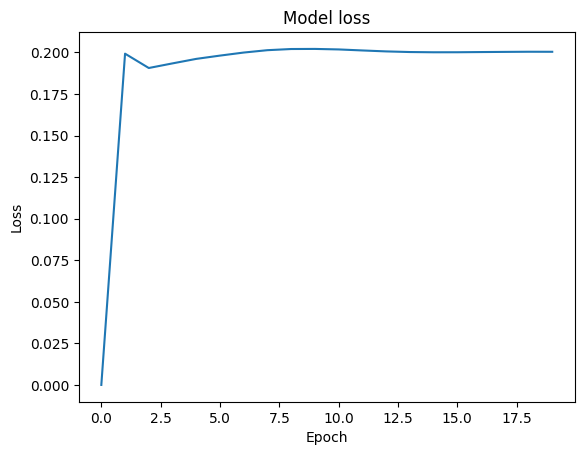

In [42]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [43]:
autoencoder_model.save_weights('./model_weights.weights.h5')

In [44]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))

    return see_Spixel, see_Cpixel

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


In [45]:
def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()

    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)

    imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])

    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, normed=1, alpha=0.75, facSecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])

    plt.show()


In [46]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

S error per pixel [0, 255]: 115.53214
C error per pixel [0, 255]: 48.818493


In [47]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

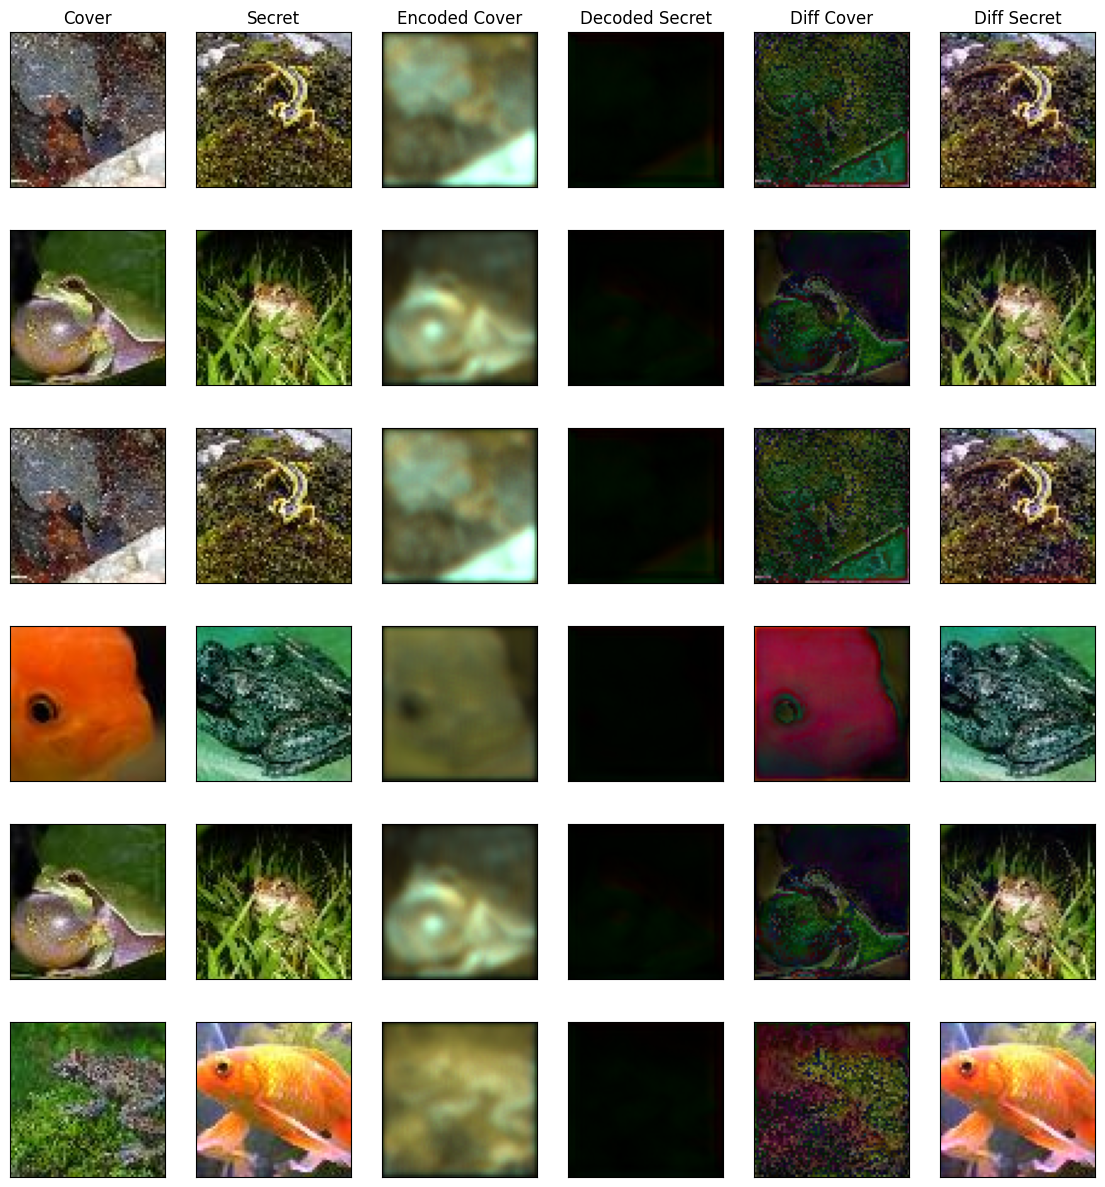

In [48]:
plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, len(input_C) - 1) for x in range(n)]

for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4

    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')
    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()


In [49]:
from google.colab import files
files.download('./model_weights.weights.h5')
#files.download('./model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>